# Non - Financial Time Series Project

Select and analyze a real-world non-financial time series dataset

1. Perform exploratory analysis.

2. Apply appropriate models.

3. Evaluate fit of the models.

4. Generate forcasts.


## Import packages

In [1]:
# pip install neuralprophet
# pip install plotly plotly-resampler
# pip install ipywidgets

In [2]:
import warnings
import logging
warnings.filterwarnings("ignore",message=".*pkg_resources is deprecated as an API.*")
warnings.filterwarnings("ignore", message=".*DataFrameGroupBy.apply operated on the grouping columns.*")
warnings.filterwarnings("ignore", message=".*Series.view is deprecated and will be removed.*")
warnings.filterwarnings("ignore", message=".*MPS available but not used.*")
logging.getLogger("py.warnings").setLevel(logging.ERROR)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid # for parameter grid search
import sklearn.metrics as skm # for metrics calculation
from joblib import Parallel, delayed # for paralelization
from sklearn.model_selection import ParameterGrid # for parameter grid search


import matplotlib.pyplot as plt # for plotting
import plotly.graph_objects as go  # for plotting

# statsmodels for time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# neuralprophet for time series forecasting
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

set_log_level("ERROR")
set_random_seed(1234)



## Import data

In [4]:
file_path = ''
data = pd.read_excel(file_path+"CRTM_Evolucion_demanda_diaria.xlsx", sheet_name='diaria',header=1)
data = data.iloc[:,1:7].rename(columns={'Unnamed: 1':'ds','Total':'y'})
data = data[['ds','y']]
data

,ds,y
0,2023-01-01,1335877
1,2023-01-02,3640967
2,2023-01-03,4106050
3,2023-01-04,4206309
4,2023-01-05,4034348
...,...,...
1053,2025-11-19,6385545
1054,2025-11-20,6364415
1055,2025-11-21,6373187
1056,2025-11-22,4087372


# Exploratory analysis

### Initial time series plot

Perform the initial time series plot to analyze the time series behaviour

In [5]:

fig = go.Figure()
fig.add_trace( go.Scatter(x=data["ds"], y=data['y'], mode="lines",name="Total", line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="Madrid public transport demand", xaxis_title="Date", yaxis_title="Users",
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    yaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()

The time series of the public transport demand shows a slightly ascending trend, since during 2023 the daily demand ranges between 2M - 5.5M users, while during 2025 in has shown that the demand has increased to +2M - +6M users per day.<br>
The time series exhibits a clear weekly seasonality, where during the weekdays the daily demand is about 5M users, while during the weekends the transport demand lowers drastically aproximately 2M. <br>
Also, the time series shows monthly seasonality, with really low demand in summer between July-Aug to just 3.5M daily users during weekdays, as well for the christmas holidays where it lowers to ~4.5M users on weekdays.

### Time series decomposition

Fit a simple neural prophet model to capture the automatic generated decomposition between trend and

In [6]:
# Create a NeuralProphet model with default parameters
m = NeuralProphet(
    learning_rate=0.01
)

metrics = m.fit(data,progress=False)
df_future = m.make_future_dataframe(data, n_historic_predictions=True)
forecast = m.predict(df_future)
m.plot_parameters(components=["trend",'seasonality'])


FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'b1f2c435-45bf-447e-856c-33f3baea1be1',
              'x': array([datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 2, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0), ...,
                          datetime.datetime(2025, 11, 20, 0, 0),
                          datetime.datetime(2025, 11, 21, 0, 0),
                          datetime.datetime(2025, 11, 23, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([4023919.78203219, 4026698.89850693, 4029478.01498167, ...,
                          4924135.95372915, 4924757.49294461, 4926000.57137553]),
              'yaxis': 'y'},
             {'fill': 'none',
      

Based on the decomposition made with the NeuralProphet model we could see that the series exhibits a growing trend. <br
The model also captured the yearly seasonality that shows a drop in the demand in December, July, and mainly in August. while the yearly seasonality shows an increase in demand February, October and November. <br>
The model also captured the weekly seasonality, where it shows the clearly demand drop during the weekends, mainly on sundays, while during the weekdays the demand is stable.

# SARIMA model

## SARIMA Model identification

The SARIMA model requires the data to be stationary with a diferencing, aditionally, it requieres to identify the frequency of the seasonality and its differencing. <br>

Since the data exhibits a low steady upward trend we could try to make it stationary by a simple differencing of the series. <br>
Additionally, the series also exhibits two seasonalities so we have to identify which of the seasonalities (weekly or yearly) have a greater inpact in the series, to apply the seasonal differencing to the simple difference series, for create a series without trend and seasonality.

In [7]:
series = data[['ds','y']].set_index('ds')['y']

# Compute the first (non-seasonal) difference
diff_series = series.diff().dropna()
adf_diff = adfuller(diff_series)
p_value_diff = adf_diff[1]

fig = go.Figure()
fig.add_trace( go.Scatter(x=diff_series.index, y=diff_series, mode="lines",name="First difference (d=1)", line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="First difference (d=1)", xaxis_title="Date", yaxis_title="Value",
    annotations=[ dict( text=f"ADF p-value: {p_value_diff:.4f}", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ],
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    yaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()


seasonal365_diff = diff_series.diff(365).dropna()
adf_s365_diff = adfuller(seasonal365_diff)
p_value_s365_diff = adf_s365_diff[1]

fig = go.Figure()
fig.add_trace( go.Scatter(x=seasonal365_diff.index, y=seasonal365_diff, mode="lines",name="Both difference (d=1, D=1, s=365)", line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="Both difference (d=1, D=1, s=365)", xaxis_title="Date", yaxis_title="Value",
    annotations=[ dict( text=f"ADF p-value: {p_value_s365_diff:.4f}", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ],
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    yaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()

seasonal7_diff = diff_series.diff(7).dropna()
adf_s7_diff = adfuller(seasonal7_diff)
p_value_s7_diff = adf_s7_diff[1]

fig = go.Figure()
fig.add_trace( go.Scatter(x=seasonal7_diff.index, y=seasonal7_diff, mode="lines",name="Both difference (d=1, D=1, s=7)", line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="Both difference (d=1, D=1, s=7)", xaxis_title="Date", yaxis_title="Value",
    annotations=[ dict( text=f"ADF p-value {p_value_s7_diff:.4f}", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ],
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    yaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()

The simple differencing removed the trend, however, it still exhibits the two seasonalities. Adding the yearly seasonal differencing still shows some yearly seasonality, and at the same time it has a strong weekly seasonality. On the other hand, adding the weekly seasonality shows a more stable series.  

Text(0.5, 1.0, 'PACF of Series with both Differences (d=1, D=1, s=7) ')

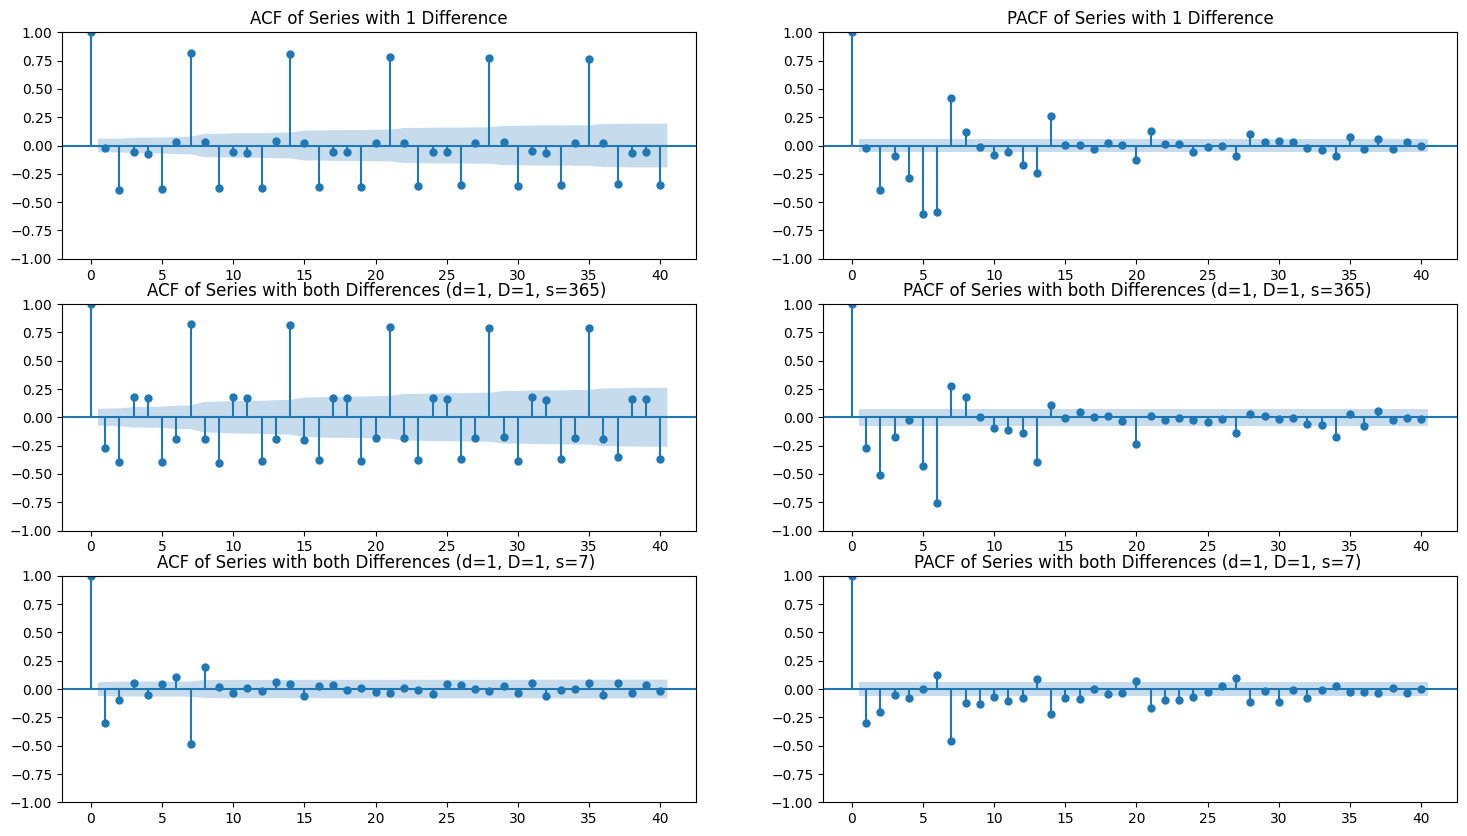

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(18, 10))

sm.graphics.tsa.plot_acf(diff_series, lags=40, ax=axs[0,0])
axs[0,0].set_title("ACF of Series with 1 Difference")

sm.graphics.tsa.plot_pacf(diff_series, lags=40, ax=axs[0,1], method='ywm')
axs[0,1].set_title("PACF of Series with 1 Difference")

sm.graphics.tsa.plot_acf(seasonal365_diff, lags=40, ax=axs[1,0])
axs[1,0].set_title("ACF of Series with both Differences (d=1, D=1, s=365) ")

sm.graphics.tsa.plot_pacf(seasonal365_diff, lags=40, ax=axs[1,1], method='ywm')
axs[1,1].set_title("PACF of Series with both Differences (d=1, D=1, s=365) ")

sm.graphics.tsa.plot_acf(seasonal7_diff, lags=40, ax=axs[2,0])
axs[2,0].set_title("ACF of Series with both Differences (d=1, D=1, s=7) ")

sm.graphics.tsa.plot_pacf(seasonal7_diff, lags=40, ax=axs[2,1], method='ywm')
axs[2,1].set_title("PACF of Series with both Differences (d=1, D=1, s=7) ")

After plotting the ACF and PACF for the diferenced series we could see how the d=1, D=1 & s=7 is the best approach to mode this data since it exhibits a more stable autocorrelation that stablizes after some lags, while the other apporaches doesn't seams to have a stable autocorrelation nor partical autocorrelation. <br>
Focusing in the d=1, D=1 & s=7 approach, we could see that the ACF show a gradual decay that suggest a autocorrelation in the data. The PACF shows partial autocorrelation in lag one and maybe up to the 2nd lag. <br>
For the the autocorrelation repeats on the next seasonality period (after lag 7) but with a lower effect until breaking into 0. <br>
Therefore, to model the data with a seasonal arima we could try to iterate over the first 2 lags for the non seasonal part both for the AR(p) and the MA(q), and seasonal part AR(P) and MA(Q).

## SARIMA Model selection

We would perform a loop over the different possible parameters combinations that the SARIMA has backed up in the ACF, PACF with a series with d=1, D=1 & s=7. <br>
For the model selection we are going to train the model with data before september 2025, to perform an in sample validation with the RMSE, MAE and MAPE metrics of the fitted values. Also, for the out of sample validation we are going to forecast 3 months of data, Sep-Nov 2025, and capture the RMSE, MAE and MAPE metrics of the forecast.

In [9]:

param_grid = {
    'p':range(3),
    'd':[1],
    'q':range(3),
    'P':range(3),
    'D':[1],
    'Q':range(3),
    's':[7]
}

param_list = ParameterGrid(param_grid)
param_list = [params for params in param_list]
print('grid length:',len(param_list))

grid length: 81


In [10]:
#create a funtion to evaluate the SARIMA model
def Eval_SARIMA(params, series, file_name, residuals = False, forecast = False):

    train = series.loc[series.index < '2025-09-11']
    val = series.loc[series.index >= '2025-09-11']

    order = (
    params['p'],
    params['d'],
    params['q']
    )
    seasonal_order = (
    params['P'],
    params['D'],
    params['Q'],
    params['s']
    )

    sarima = sm.tsa.SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order
    )

    sarima_results = sarima.fit(disp=False)

    mae = skm.mean_absolute_error(train,sarima_results.fittedvalues)
    rmse = skm.root_mean_squared_error(train,sarima_results.fittedvalues)
    mape = skm.mean_absolute_percentage_error(train,sarima_results.fittedvalues)



    if forecast:
        sarima_forecast = sarima_results.get_forecast(len(val)).predicted_mean
        yhat = pd.DataFrame(sarima_forecast).rename(columns={'predicted_mean':'yhat'})
        y = pd.DataFrame(series).rename(columns={'Total':'y'})
        forecast_df = sarima_results.get_forecast(len(val)).conf_int(90)
        forecast_df = forecast_df.merge(yhat, left_index=True, right_index=True).merge(y, left_index=True, right_index=True, how='right')

        return forecast_df


    if residuals:
        fitted_resid = sarima_results.resid
        return fitted_resid

    if not (residuals or forecast):

        sarima_forecast = sarima_results.get_forecast(len(val)).predicted_mean
        mae_val = skm.mean_absolute_error(val,sarima_forecast)
        rmse_val = skm.root_mean_squared_error(val,sarima_forecast)
        mape_val = skm.mean_absolute_percentage_error(val,sarima_forecast)

        results = {
            'p':params['p'],
            'd':params['d'],
            'q':params['q'],
            'P':params['P'],
            'D':params['D'],
            'Q':params['Q'],
            's':params['s'],
            'mae_train': mae,
            'rmse_train': rmse,
            'mape_train': mape,
            'mae_val': mae_val,
            'rmse_val': rmse_val,
            'mape_val': mape_val
        }

        results_dict_df = pd.DataFrame([results])
        results_dict_df.to_csv(file_name,index=False,mode='a',header=False)




        return results





In [ ]:
## RUN THIS ONCE to create the csv file and run the CV, afterwards just read the csv file
# Initialize results storage
file_name = 'SARIMA_metro_demand_s7.csv'
results_df = pd.DataFrame(columns=['p','d','q','P','D','Q','s','mae_train','rmse_train','mape_train','mae_val','rmse_val','mape_val'])
results_df.to_csv(file_name,index=False)

# Evaluate SARIMA models with the grid search in parallel
series = data[['ds','y']].set_index('ds')['y']
CV_results = Parallel(n_jobs=1)(delayed(Eval_SARIMA)(params = HyperParams, series = series, file_name = file_name) for HyperParams in param_list)


In [11]:
sarima_results = pd.read_csv('SARIMA_metro_demand_s7.csv')
sarima_results.loc[sarima_results['rmse_val'] == sarima_results['rmse_val'].min()]

,p,d,q,P,D,Q,s,mae_train,rmse_train,mape_train,mae_val,rmse_val,mape_val
36,0,1,0,1,1,1,7,368717.527731,660683.355173,0.106436,355689.868808,461735.540563,0.0821


Based on the rmse of the fitted values, the best model is the a SARIMA(p=1,d=1,q=2)(P=2,D=1,Q=2,s=7) with a mean absolute error of 360843, rmse of 605829, and a mape of just 10.6% of the fitted values. While for the out of sample predictions it has an mean absolute error of 507841, a similar rmse to the fitted values of 605268, and a mape of 9.2%

In [12]:
best_sarima_results = sarima_results.loc[sarima_results['rmse_val'] == sarima_results['rmse_val'].min()]
best_sarima_results = dict(best_sarima_results.iloc[0])

## SARIMA best model Fit

In [13]:
final_sarima_residuals = Eval_SARIMA(params = best_sarima_results, series = series, file_name = '', residuals = True)
fig = go.Figure()
fig.add_trace( go.Scatter(x=final_sarima_residuals.index, y=final_sarima_residuals, mode="lines",name="SARIMA residuals", line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="Time series of SARIMA residuals", xaxis_title="Date", yaxis_title="Value",
    annotations=[ dict( text=f"SARIMA({best_sarima_results['p']},1,{best_sarima_results['q']})({best_sarima_results['P']},1,{best_sarima_results['Q']},7)", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ],
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    yaxis=dict( showline=True, linewidth=2, linecolor="#ebf0f8", mirror=True, showgrid=True, gridcolor="#ebf0f8", zeroline=False ),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()

from the model residuals we still see some months with a greater level of residuals than others, mainly due to the yearly seasonality that it isnt captured in the model. We also see some big spikes, mainly caused by the specific holidays.

Ljung-Box p-value: 0.0000


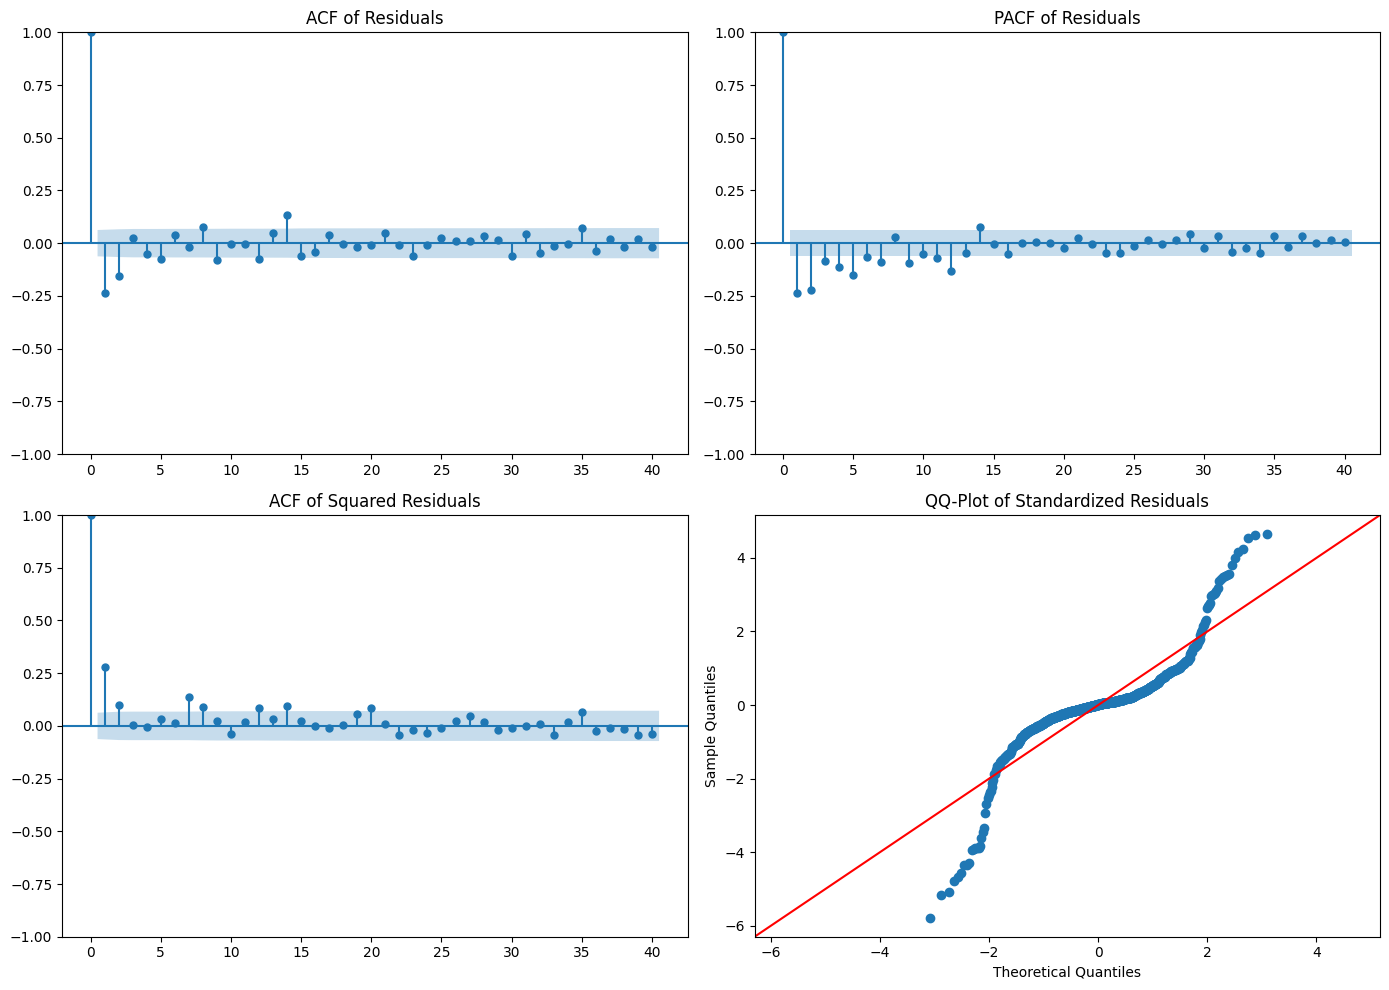

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'best_result' is your fitted model from which we extract residuals.
resid = final_sarima_residuals
resid_sq = resid ** 2

ljungbox_result = acorr_ljungbox(resid, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")
# Standardize the residuals for the QQ-plot.
resid_std = (resid - resid.mean()) / resid.std()

# Create a 2x2 grid of diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Time Series of Residuals
sm.graphics.tsa.plot_acf(resid, lags=40, ax=axs[0, 0])
axs[0, 0].set_title("ACF of Residuals")

# Top-Right: ACF of Residuals
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=axs[0, 1])
axs[0, 1].set_title("PACF of Residuals")

# Bottom-Left: ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# Bottom-Right: QQ-Plot of Standardized Residuals
sm.qqplot(resid_std, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()


We run the ljung box test, to test if the residuals exhibits an an autocorrelation up to lag 20, with a p.value of 0.2897 we don't have enough statistical evidence agienst the null hypothesis, to state that the 20 lags are different from 0. <br>
Also we plot the ACF, PACF of the residuals, as well to the ACF of the squared residuals, and the QQ plot of the standarized residuals. From this plots we could see that there is no clear autocorrelation of the residuals, neither fom the squared residuals. However, the QQ plot of the standarized residuals shows heavy tails and that the residuals might be skwed to the left

## SARIMA best model validation forecast

In [15]:
final_sarima_forecast = Eval_SARIMA(params = best_sarima_results, series = series, file_name = '', forecast = True)

fig = go.Figure()

fig.add_trace( go.Scatter( x=final_sarima_forecast.index,y=final_sarima_forecast['yhat'],mode="lines",name="yhat") )
fig.add_trace( go.Scatter( x=final_sarima_forecast.index,y=final_sarima_forecast["lower y"],mode="lines",name="yhat lower bound",line=dict(color="rgba(0,0,0,0)"),showlegend=False,hoverinfo="skip" ) )
fig.add_trace( go.Scatter(x=final_sarima_forecast.index,y=final_sarima_forecast["upper y"],mode="lines",name="90% CI",line=dict(color="rgba(0,0,0,0)"),fill="tonexty",fillcolor="rgba(65,105,225,0.2)" ) )
fig.add_trace( go.Scatter( x=final_sarima_forecast.index,y=final_sarima_forecast["y"],mode="lines",marker=dict(size=5),name="Actual" ) )
fig.update_layout(
    title="Forecast for September-November 2025", xaxis_title="Date", yaxis_title="Users",
    annotations=[ dict( text=f"RMSE: {round(best_sarima_results['rmse_val'])}, MAE: {round(best_sarima_results['mae_val'])}, MAPE: {round(best_sarima_results['mape_val']*100,1)}%", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ],
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8",mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    yaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8",mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()

## SARIMA best model forecast

In [16]:
sarima = sm.tsa.SARIMAX(
    series,
    order = (best_sarima_results['p'],best_sarima_results['d'],best_sarima_results['q']),
    seasonal_order = (best_sarima_results['P'],best_sarima_results['D'],best_sarima_results['Q'],best_sarima_results['s'])
)

sarima_results = sarima.fit(disp=False)

sarima_forecast = sarima_results.get_forecast(38).predicted_mean
yhat = pd.DataFrame(sarima_forecast).rename(columns={'predicted_mean':'yhat'})
y = pd.DataFrame(series).rename(columns={'Total':'y'})
forecast_df = sarima_results.get_forecast(38).conf_int()
forecast_df = forecast_df.merge(yhat, left_index=True, right_index=True).merge(y, left_index=True, right_index=True, how='outer')

In [17]:
fig = go.Figure()

fig.add_trace( go.Scatter( x=forecast_df.index,y=forecast_df['yhat'],mode="lines",name="yhat") )
fig.add_trace( go.Scatter( x=forecast_df.index,y=forecast_df["lower y"],mode="lines",name="yhat lower bound",line=dict(color="rgba(0,0,0,0)"),showlegend=False,hoverinfo="skip" ) )
fig.add_trace( go.Scatter(x=forecast_df.index,y=forecast_df["upper y"],mode="lines",name="90% CI",line=dict(color="rgba(0,0,0,0)"),fill="tonexty",fillcolor="rgba(65,105,225,0.2)" ) )
fig.add_trace( go.Scatter( x=forecast_df.index,y=forecast_df["y"],mode="lines",marker=dict(size=5),name="Actual" ) )
fig.update_layout(
    title="Forecast for December 2025", xaxis_title="Date", yaxis_title="Users",
    plot_bgcolor="white", paper_bgcolor="white",
    xaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8",mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    yaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8",mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()

**Technical interpretation:** The forecast for December 2025 accurately predicts the weekly seasonality with the dropdowns during weekends, but it understimates the seasonality as the predicted dropdowns are lower than the ones from the latests weeks. Also, it doesn't capture the possible decrease in demand during the christmas holidays. 
Uncertainty level increases quickly while the forecast horizon increases, with really wide confidence intervals. <br>

**Business interpretations:** Expected demand in December 2025 will follow typical weekly patterns, with high demand during the weekdays and low demand during the weekends. The model does not predict a large growth or decline by December 2025, no anomalies or Christmas holidays and yearly seasonality change in demand predicted.

# Neural Prophet Model

## Neural Prophet model identification

For trying to account for the yearly seasonality and the holidays, we are going to model the data with the NeuralProphet, a model developed by meta that decomposed the time series by its components trend, yearly and weekly seasonality with fourier series. It also model the autorregressive part of the model with a neural network calle AR-Net.<br>
You could also include in the model public holidays dummies with different lags or leads, there are some public holidays in the Neural Prophet package, but you could also add additional holidays that aren't included in those public holidays, like the Madrid specific holidays.

In [18]:

SanJose = pd.DataFrame(
    {
        "event": "Natividad de San Jose",
        "ds": pd.to_datetime(
            [
                "2023-03-20"
            ]
        ),
    }
)
JuevesSanto = pd.DataFrame(
    {
        "event": "Jueves Santo",
        "ds": pd.to_datetime(
            [
                "2023-04-06",
                "2024-03-28",
                "2025-04-17"
            ]
        ),
    }
)
ComunidadMadrid = pd.DataFrame(
    {
        "event": "Comunidad de Madrid",
        "ds": pd.to_datetime(
            [
                "2023-05-02",
                "2024-05-02",
                "2025-05-02"
            ]
        ),
    }
)
SanIsidro = pd.DataFrame(
    {
        "event": "San Isidro",
        "ds": pd.to_datetime(
            [
                "2023-05-15",
                "2024-05-15",
                "2025-05-15"
            ]
        ),
    }
)
Almudena = pd.DataFrame(
    {
        "event": "Fiesta de la Almudena",
        "ds": pd.to_datetime(
            [
                "2023-11-09",
                "2025-11-10"
            ]
        ),
    }
)
MadridHolidays = pd.concat([SanJose, JuevesSanto, ComunidadMadrid, SanIsidro, Almudena])


Create an automatic Neural prophet model with the automatically generated decomposition between trend, yearly and weekly seasonality, adding the holidays to inspect the residuals with the ACF and PACF for the AR part of the model.

In [19]:
# Create a NeuralProphet model with default parameters
mhm = NeuralProphet(
    n_changepoints=6,
    learning_rate=0.01
)
mhm = mhm.add_country_holidays("Spain")

mhm.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"])
df_all = mhm.create_df_with_events(data, MadridHolidays)

metrics = mhm.fit(df_all, progress=False)
df_all_future = mhm.make_future_dataframe(df_all, n_historic_predictions=True)
df_all_future = df_all_future.dropna()
forecast_mhm = mhm.predict(df_all_future)

df_residuals_mhm = pd.DataFrame({"ds": data["ds"], "residuals": data["y"] - forecast_mhm["yhat1"]})
df_residuals_mhm = df_residuals_mhm.dropna()

fig = go.Figure()

# Forecast line (yhat1)

fig.add_trace(
    go.Scatter(
        x=df_residuals_mhm["ds"],
        y=df_residuals_mhm["residuals"],
        mode="lines",
        name="residuals",
        line=dict(color="#2d92ff", width=2)
    )
)

fig.update_layout(
    title="Residuals of trend & seasonality (+holidays) model",
    xaxis_title="Date",
    yaxis_title="Residuals",

    plot_bgcolor="white",
    paper_bgcolor="white",

    xaxis=dict(
        showline=True,
        linewidth=2,          # border thickness
        linecolor="#ebf0f8",    # border color
        mirror=True,
        showgrid=True,
        gridcolor="#ebf0f8",
        zeroline=False
    ),
    yaxis=dict(
        showline=True,
        linewidth=2,          # border thickness
        linecolor="#ebf0f8",    # border color
        mirror=True,
        showgrid=True,
        gridcolor="#ebf0f8",
        zeroline=False
    ),

    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()


Dickey-fuller test p-value: 9.94026593436519e-15


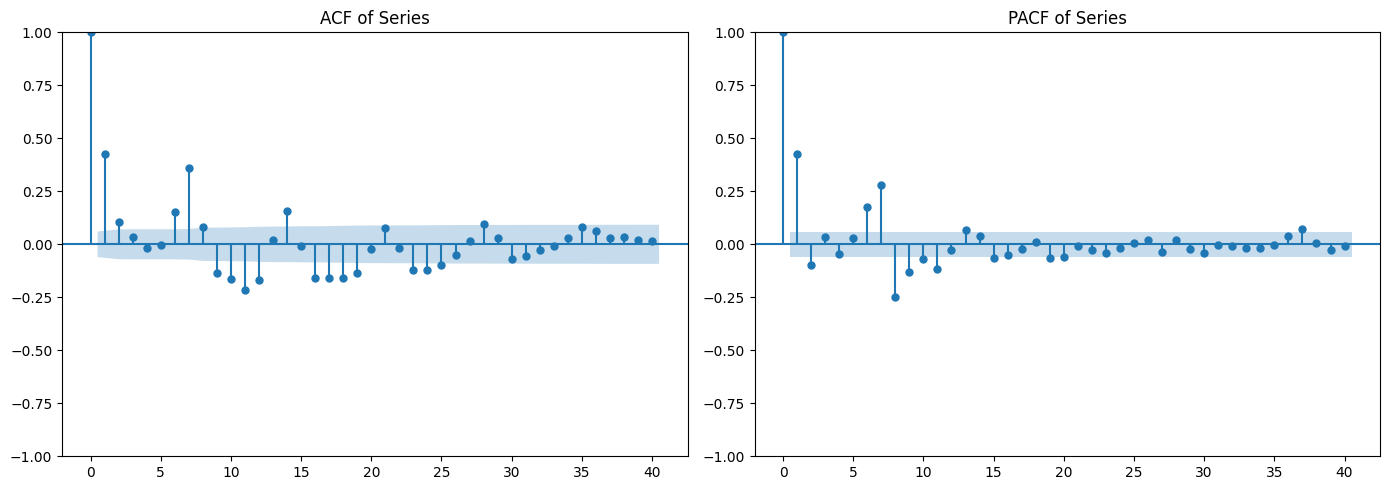

In [20]:
adf = adfuller(df_residuals_mhm['residuals'])
print('Dickey-fuller test p-value:', adf[1])

# Create ACF and PACF plots for the series with both differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(df_residuals_mhm['residuals'], lags=40, ax=axs[0])
axs[0].set_title("ACF of Series")

# PACF Plot
sm.graphics.tsa.plot_pacf(df_residuals_mhm['residuals'], lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series")

plt.tight_layout()
plt.show()

The both the time series of the residuals and, the ACF and PACF shows there are still a lot of information in the residuals, with big auto correlation influence, up to the lag 12, but we could see that there is a lower seasonality influence in the residuals.

## Neural Prophet model selection

For the parameter search we would search for high AR parameters, but we also could tweek a lot of the trend, seasonality and holidays hyperparameters. For the trend we are going to search over the number of times the trend could change over the fitting data (n_changepoints). For the the seasonality we are going to search for the number of fourier series in the weekly and yearly seasonalities, the mode it enter in the model (additive,multiplicative) and the amount of regularization we want to have for the seasonality effect. Finally we would also search for models hyperparameters for the holidays components, the mode it enter the model (additive,multiplicative) and the amount of regularization we want to have for the holidays effect.

In [21]:
from sklearn.model_selection import ParameterGrid # for parameter grid search
from joblib import Parallel, delayed # for paralelization

param_grid = {
    'n_changepoints': [3,6],
    'p':range(9,13),
    'seasonality_mode':['additive','multiplicative'],
    'year_seasonality_fourier':[10,8,6],
    'week_seasonality_fourier':[3,6],
    'seasonality_reg':[1,100],
    'holidays_mode':['additive','multiplicative'],
    'holidays_reg':[0.01,1,100]
}

param_list = ParameterGrid(param_grid)
param_list = [params for params in param_list]
print('param grid lenght:',len(param_list))

param grid lenght: 1152


In [22]:
## create a funtion to evaluate the NeuralProphet model
def evaluate_hyperparams_complete(data, params, lr=0.01, file_name='NeuralProphet_metro_demand.csv'):
    import torch, random, numpy as np
    from neuralprophet import NeuralProphet, set_random_seed

    # Reset seeds for each run
    random.seed(1234)
    np.random.seed(1234)
    torch.manual_seed(1234)
    set_random_seed(1234)

    # Deterministic cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = NeuralProphet(
    n_changepoints=params['n_changepoints'],
    n_lags=params['p'],
    learning_rate=lr,
    yearly_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode=params['seasonality_mode'],
    seasonality_reg=params['seasonality_reg']
    )

    model = model.add_seasonality(name='year', period=365.25, fourier_order=params['year_seasonality_fourier'])
    model = model.add_seasonality(name='week', period=7, fourier_order=params['week_seasonality_fourier'])

    model = model.add_country_holidays("Spain",mode=params['holidays_mode'],regularization=params['holidays_reg'],lower_window=-1,upper_window=1)
    model.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"], mode=params['holidays_mode'],regularization=params['holidays_reg'],lower_window=-1,upper_window=1)
    data_model = model.create_df_with_events(data, MadridHolidays)


    # Split data
    train = data_model.loc[data_model['ds'] < '2025-09-11']
    val = data_model.loc[data_model['ds'] >= '2025-09-11']

    metrics = model.fit(train, validation_df=val, progress=None)
    metrics_dict = {'RMSE_val':metrics["RMSE_val"].mean(),'MAE_val':metrics["MAE_val"].mean(), 'MAE':metrics["MAE"].mean(), 'RMSE':metrics["RMSE"].mean(), 'params':params}

    results_dict_df = pd.DataFrame([metrics_dict])
    results_dict_df.to_csv(file_name,index=False,mode='a',header=False)
    return metrics_dict


In [ ]:
## RUN THIS ONLY ONCE to create the csv file and run the CV, afterwards just read the csv file
# Initialize results storage
cv_df = pd.DataFrame(columns=['RMSE_val','MAE_val','MAE','RMSE','params']).to_csv('NeuralProphet_metro_demand_complete.csv',index=False)
# Evaluate NeuralProphet models with the grid search in parallel
CV_results = Parallel(n_jobs=1)(delayed(evaluate_hyperparams_complete)(data = data, params = params, lr=0.01, file_name='NeuralProphet_metro_demand_complete.csv') for params in param_list)

In [23]:
CV_results = pd.read_csv('NeuralProphet_metro_demand_complete.csv')
CV_min = CV_results.loc[CV_results['RMSE_val'] == CV_results['RMSE_val'].min()]
CV_min

,RMSE_val,MAE_val,MAE,RMSE,params
565,543679.549432,358622.624432,315288.051989,456025.574432,"{'holidays_mode': 'additive', 'holidays_reg': ..."


We selected the model that has the lower RMSE for the out of sample validation with an validation RMSE of 543679. The following are the hyperparameters of the model.

In [24]:
import ast
CV_min_params = ast.literal_eval( CV_min['params'].values[0])
CV_min_params

{'holidays_mode': 'additive',
 'holidays_reg': 100,
 'n_changepoints': 6,
 'p': 12,
 'seasonality_mode': 'multiplicative',
 'seasonality_reg': 1,
 'week_seasonality_fourier': 3,
 'year_seasonality_fourier': 8}

## Neural Prophet best model fit

In [25]:
import torch, random, numpy as np
from neuralprophet import NeuralProphet, set_random_seed

lr=0.01

# Reset seeds for each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
set_random_seed(1234)

# Deterministic cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = NeuralProphet(
n_changepoints=CV_min_params['n_changepoints'],
n_lags=CV_min_params['p'],
learning_rate=lr,
yearly_seasonality=False,
weekly_seasonality=False,
seasonality_mode=CV_min_params['seasonality_mode'],
seasonality_reg=CV_min_params['seasonality_reg'],
)

model = model.add_seasonality(name='year', period=365.25, fourier_order=CV_min_params['year_seasonality_fourier'])
model = model.add_seasonality(name='week', period=7, fourier_order=CV_min_params['week_seasonality_fourier'])

model = model.add_country_holidays("Spain",mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
model.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"], mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
data_model = model.create_df_with_events(data, MadridHolidays)


data_model = model.create_df_with_events(data, MadridHolidays)

train = data_model.loc[data_model['ds']<'2025-09-11']
val = data_model.loc[data_model['ds']>='2025-09-11']

metrics = model.fit(train, progress=False)

data_model_future = model.make_future_dataframe(train, n_historic_predictions=True)
forecast = model.predict(data_model_future)

model.plot_parameters(components=["trend",'seasonality'])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'type': 'scatter',
              'uid': '74d3b3b8-cb53-4aee-9d87-cc763f07fad1',
              'x': array([datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 2, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0), ...,
                          datetime.datetime(2025, 9, 8, 0, 0),
                          datetime.datetime(2025, 9, 9, 0, 0),
                          datetime.datetime(2025, 9, 10, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([4107861.58582619, 4109821.3975126 , 4111781.20919902, ...,
                          5020619.29691489, 5021993.10617607, 5023366.91543724]),
              'yaxis': 'y'},
             {'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'l

The model incorporates adequately the trend, and seasonalities of the time series.

In [26]:
fc = forecast.loc[(~forecast['yhat1'].isna())&(~forecast['y'].isna()), ['ds', 'y','yhat1']]
fc['residuals'] = fc['y'] - fc['yhat1']

residuals = fc[['ds','residuals']]

fig = go.Figure()
fig.add_trace( go.Scatter( x=residuals["ds"],y=residuals["residuals"],mode="lines",name="residuals",line=dict(color="#2d92ff", width=2) ) )
fig.update_layout(
    title="Residuals of trend, seasonality (+holidays) & AR model",
    xaxis_title="Date",
    yaxis_title="Residuals",
    plot_bgcolor="white", paper_bgcolor="white", 
    xaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True, gridcolor="#ebf0f8",zeroline=False),
    yaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True, gridcolor="#ebf0f8",zeroline=False),
    margin=dict(l=80, r=40, t=80, b=60)
)
fig.show()


Ljung-Box p-value: 0.0093


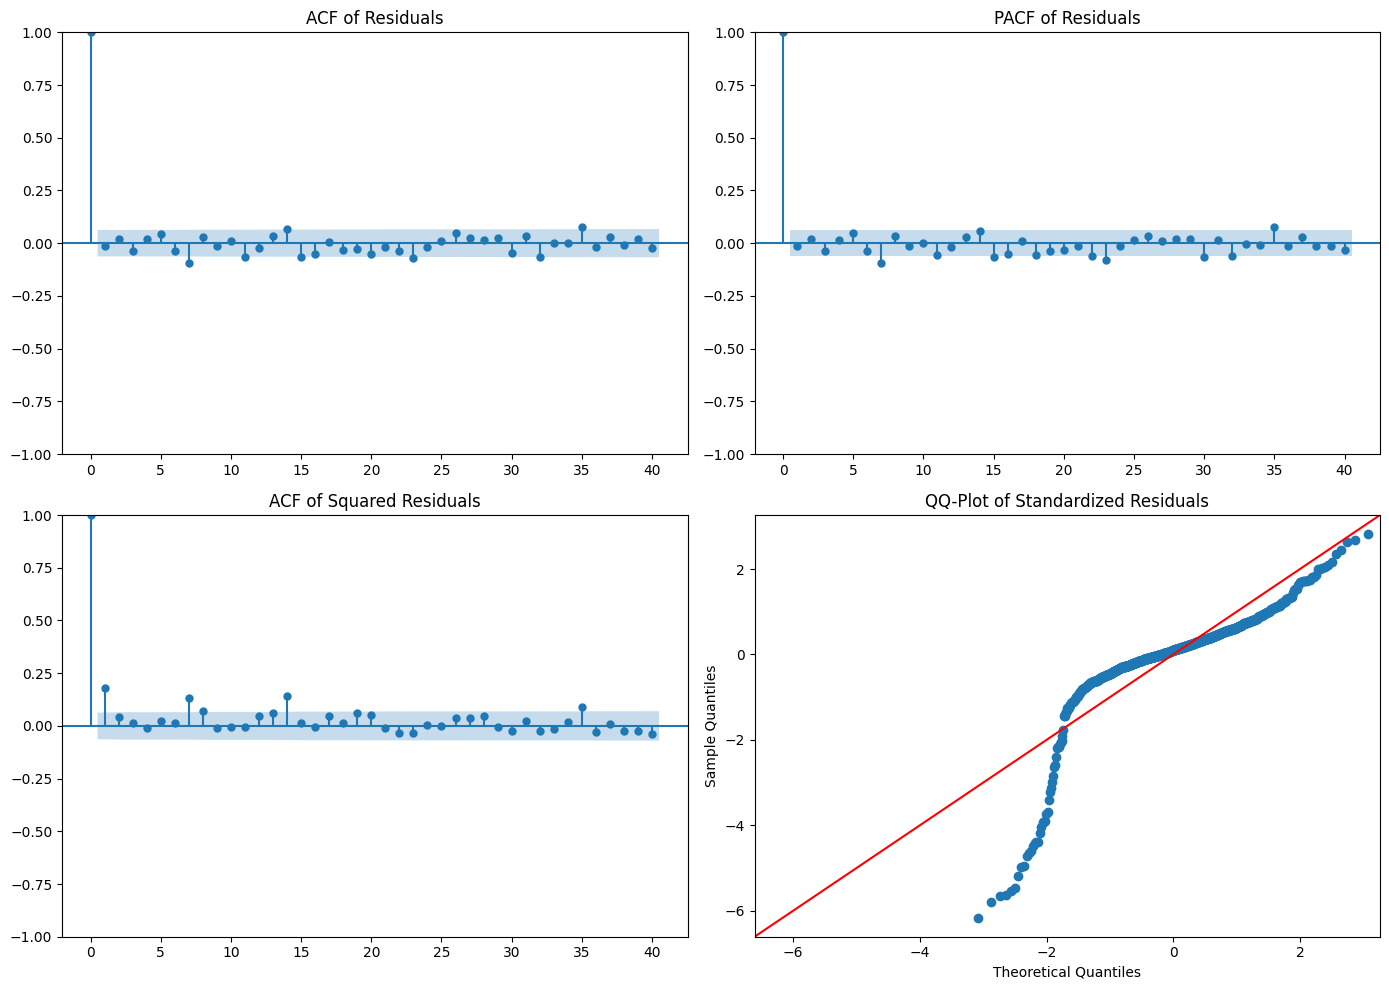

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'best_result' is your fitted model from which we extract residuals.
resid = residuals["residuals"]
resid_sq = resid ** 2

residual_q05 = resid.quantile(0.05)
residual_q95 = resid.quantile(0.95)

ljungbox_result = acorr_ljungbox(resid, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")

# Standardize the residuals for the QQ-plot.
resid_std = (resid - resid.mean()) / resid.std()

# Create a 2x2 grid of diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Time Series of Residuals
sm.graphics.tsa.plot_acf(resid, lags=40, ax=axs[0, 0])
axs[0, 0].set_title("ACF of Residuals")

# Top-Right: ACF of Residuals
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=axs[0, 1], method='ywm')
axs[0,1].set_title("PACF of Residuals")

# Bottom-Left: ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# Bottom-Right: QQ-Plot of Standardized Residuals
sm.qqplot(resid_std, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()

The ACF and PACF of the residuals shows that there is no autocorrelation on the residuals. However, the p-value of the ljung box test is 0.0093 that gave us enough evidence to state that we still have some information in the residuals. Indeed, the ACF of the squared residuals and the time series plot of the residuals confirm us this, with some spikes on specific public holidays. Although, the QQ plot shows us that there is a part of the residuals that follow closely an standard normal, but they had skweed heavy left tail. 

## Neural Prophet best model validation forecast 

In [28]:
import torch, random, numpy as np
from neuralprophet import NeuralProphet, set_random_seed

lr=0.01

# Reset seeds for each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
set_random_seed(1234)

# Deterministic cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = NeuralProphet(
n_changepoints=CV_min_params['n_changepoints'],
n_lags=CV_min_params['p'],
learning_rate=lr,
yearly_seasonality=False,
weekly_seasonality=False,
seasonality_mode=CV_min_params['seasonality_mode'],
seasonality_reg=CV_min_params['seasonality_reg'],
n_forecasts=74,
)

model = model.add_seasonality(name='year', period=365.25, fourier_order=CV_min_params['year_seasonality_fourier'])
model = model.add_seasonality(name='week', period=7, fourier_order=CV_min_params['week_seasonality_fourier'])

model = model.add_country_holidays("Spain",mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
model.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"], mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
data_model = model.create_df_with_events(data, MadridHolidays)


data_model = model.create_df_with_events(data, MadridHolidays)

train = data_model.loc[data_model['ds']<'2025-09-11']
val = data_model.loc[data_model['ds']>='2025-09-11']

metrics = model.fit(train, progress=False)

data_model_future = model.make_future_dataframe(train, n_historic_predictions=True, periods=74)
forecast = model.predict(data_model_future)

In [29]:
for i in range(1,75):
    if i == 1:
        date_1 = forecast[forecast[f"yhat{i}"].notna()].iloc[-2]['ds']
        y = forecast[forecast[f"yhat{i}"].notna()].iloc[-2]['y']
        forecast.loc[forecast['ds']==date_1,'yhat'] = y
        forecast.loc[forecast['ds']==date_1,'yhat_lb'] = y
        forecast.loc[forecast['ds']==date_1,'yhat_ub'] = y

    date = forecast[forecast[f"yhat{i}"].notna()].iloc[-1]['ds']
    yhat = forecast[forecast[f"yhat{i}"].notna()].iloc[-1][f'yhat{i}']
    yhat_lb = yhat+residual_q05
    yhat_ub = yhat+residual_q95
    
    forecast.loc[forecast['ds']==date,'yhat'] = yhat
    forecast.loc[forecast['ds']==date,'yhat_lb'] = yhat_lb
    forecast.loc[forecast['ds']==date,'yhat_ub'] = yhat_ub

forecast = forecast[['ds','yhat','yhat_lb','yhat_ub']].merge(data[['ds','y']], on='ds', how='left')


In [30]:
forecast_oos = forecast[['ds','y','yhat']].loc[forecast['ds']>='2025-09-11']
rmse_np = skm.root_mean_squared_error(forecast_oos['y'],forecast_oos['yhat'])
mae_np = skm.mean_absolute_error(forecast_oos['y'],forecast_oos['yhat'])
mape_np = skm.mean_absolute_percentage_error(forecast_oos['y'],forecast_oos['yhat'])
print(f"NeuralProphet RMSE: {rmse_np}, MAE: {mae_np}, MAPE: {mape_np}")

NeuralProphet RMSE: 432079.2353346612, MAE: 256482.57432432432, MAPE: 0.06516529256361835


In [31]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["yhat"],mode="lines",name="y"))
fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["yhat_lb"],mode="lines",name="yhat lower bound",line=dict(color="rgba(0,0,0,0)"),showlegend=False,hoverinfo="skip") )
fig.add_trace( go.Scatter(x=forecast["ds"], y=forecast["yhat_ub"], mode="lines", name="90% CI", line=dict(color="rgba(0,0,0,0)"), fill="tonexty", fillcolor="rgba(65,105,225,0.2)" ) )
fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["y"],mode="lines",marker=dict(size=5),name="Actual"))


fig.update_layout(
    title="Forecast for validation period September-November 2025",
    annotations=[ dict( text=f"RMSE: {round(rmse_np)}, MAE: {round(mae_np)}, MAPE: {round(mape_np*100,1)}%", showarrow=False, xref="paper", yref="paper", x=1, y=1.15 ) ], 
    xaxis_title="Date", yaxis_title="Users",
    plot_bgcolor="white", paper_bgcolor="white", 
    xaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    yaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),    
    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()

The model in the out of sample forcast validation has a rmse of 432079, a mean absolute percentage error of 6.5% and, a mean error of approximately 256583 users. From the time series plot, you could see how the point forecast really close to the observed values. Also, you could say that the confidence interval is really narrow and close to the point forecast. 

## Neural Prophet best model forecast

In [32]:
import torch, random, numpy as np
from neuralprophet import NeuralProphet, set_random_seed

lr=0.01

# Reset seeds for each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
set_random_seed(1234)

# Deterministic cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = NeuralProphet(
n_changepoints=CV_min_params['n_changepoints'],
n_lags=CV_min_params['p'],
learning_rate=lr,
yearly_seasonality=False,
weekly_seasonality=False,
seasonality_mode=CV_min_params['seasonality_mode'],
seasonality_reg=CV_min_params['seasonality_reg'],
)

model = model.add_seasonality(name='year', period=365.25, fourier_order=CV_min_params['year_seasonality_fourier'])
model = model.add_seasonality(name='week', period=7, fourier_order=CV_min_params['week_seasonality_fourier'])

model = model.add_country_holidays("Spain",mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
model.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"], mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
data_model = model.create_df_with_events(data, MadridHolidays)


data_model = model.create_df_with_events(data, MadridHolidays)

metrics = model.fit(data_model, progress=False)

data_model_future = model.make_future_dataframe(data_model, n_historic_predictions=True)
forecast = model.predict(data_model_future)

fc = forecast.loc[(~forecast['yhat1'].isna())&(~forecast['y'].isna()), ['ds', 'y','yhat1']]
fc['residuals'] = fc['y'] - fc['yhat1']

residual_q05 = resid.quantile(0.05)
residual_q95 = resid.quantile(0.95)


In [33]:
residuals = fc[['ds','residuals']]

fig = go.Figure()

# Forecast line (yhat1)

fig.add_trace(
    go.Scatter(
        x=residuals["ds"],
        y=residuals["residuals"],
        mode="lines",
        name="residuals",
        line=dict(color="#2d92ff", width=2)
    )
)

fig.update_layout(
    title="Residuals of trend, seasonality (+holidays) & AR model",
    xaxis_title="Date",
    yaxis_title="Residuals",

    plot_bgcolor="white", 
    paper_bgcolor="white", 

    xaxis=dict(
        showline=True,
        linewidth=2,          # border thickness
        linecolor="#ebf0f8",    # border color
        mirror=True,
        showgrid=True,
        gridcolor="#ebf0f8",  
        zeroline=False
    ),
    yaxis=dict(
        showline=True,
        linewidth=2,          # border thickness
        linecolor="#ebf0f8",    # border color
        mirror=True,
        showgrid=True,
        gridcolor="#ebf0f8",
        zeroline=False
    ),

    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()


In [34]:
import torch, random, numpy as np
from neuralprophet import NeuralProphet, set_random_seed

lr=0.01

# Reset seeds for each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
set_random_seed(1234)

# Deterministic cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = NeuralProphet(
n_changepoints=CV_min_params['n_changepoints'],
n_lags=CV_min_params['p'],
learning_rate=lr,
yearly_seasonality=False,
weekly_seasonality=False,
seasonality_mode=CV_min_params['seasonality_mode'],
seasonality_reg=CV_min_params['seasonality_reg'],
n_forecasts=38,
)

model = model.add_seasonality(name='year', period=365.25, fourier_order=CV_min_params['year_seasonality_fourier'])
model = model.add_seasonality(name='week', period=7, fourier_order=CV_min_params['week_seasonality_fourier'])

model = model.add_country_holidays("Spain",mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
model.add_events(["Natividad de San Jose","Jueves Santo","Comunidad de Madrid","San Isidro","Fiesta de la Almudena"], mode=CV_min_params['holidays_mode'],regularization=CV_min_params['holidays_reg'],lower_window=-1,upper_window=1)
data_model = model.create_df_with_events(data, MadridHolidays)


data_model = model.create_df_with_events(data, MadridHolidays)

metrics = model.fit(data_model, progress=False)

data_model_future = model.make_future_dataframe(data_model, n_historic_predictions=True, periods=38)
forecast = model.predict(data_model_future)

In [35]:

for i in range(1,38):
    if i == 1:
        date_1 = forecast[forecast[f"yhat{i}"].notna()].iloc[-2]['ds']
        y = forecast[forecast[f"yhat{i}"].notna()].iloc[-2]['y']
        forecast.loc[forecast['ds']==date_1,'yhat'] = y
        forecast.loc[forecast['ds']==date_1,'yhat_lb'] = y
        forecast.loc[forecast['ds']==date_1,'yhat_ub'] = y

    date = forecast[forecast[f"yhat{i}"].notna()].iloc[-1]['ds']
    yhat = forecast[forecast[f"yhat{i}"].notna()].iloc[-1][f'yhat{i}']
    yhat_lb = yhat+residual_q05
    yhat_ub = yhat+residual_q95
    
    forecast.loc[forecast['ds']==date,'yhat'] = yhat
    forecast.loc[forecast['ds']==date,'yhat_lb'] = yhat_lb
    forecast.loc[forecast['ds']==date,'yhat_ub'] = yhat_ub

forecast = forecast[['ds','yhat','yhat_lb','yhat_ub']].merge(data[['ds','y']], on='ds', how='left')

In [36]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["yhat"],mode="lines",name="y"))
fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["yhat_lb"],mode="lines",name="yhat lower bound",line=dict(color="rgba(0,0,0,0)"),showlegend=False,hoverinfo="skip") )
fig.add_trace( go.Scatter(x=forecast["ds"], y=forecast["yhat_ub"], mode="lines", name="90% CI", line=dict(color="rgba(0,0,0,0)"), fill="tonexty", fillcolor="rgba(65,105,225,0.2)" ) )
fig.add_trace( go.Scatter(x=forecast["ds"],y=forecast["y"],mode="lines",marker=dict(size=5),name="Actual"))


fig.update_layout(
    title="Forecast for December 2025",
    xaxis_title="Date", yaxis_title="Users",
    plot_bgcolor="white", paper_bgcolor="white", 
    xaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),
    yaxis=dict(showline=True,linewidth=2,linecolor="#ebf0f8", mirror=True,showgrid=True,gridcolor="#ebf0f8",zeroline=False),    
    margin=dict(l=80, r=40, t=80, b=60)
)

fig.show()

**Technical interpretation:** The forecast for December 2025 accurately predicts the weekly seasonality with the dropdowns during weekends. Also the model accurately predicts a dropdown during december due to the Christmas seasonality, indeed, it predicts an even lower demand during the last two weeks of December given the Chirstmas and New Year holidays. The confidence intervals are narrower than the SARIMA model, which exhibits that the model have less uncertainty on its forecast, as its more driven from the seasonalities and holidays.<br>

**Business interpretations:** Forecasted December 2025 demand will be lower than autumn 2025 levels, consistent with typical public transport behavior during Christmas holidays season: fewer commuters, more holidays, reduced student traffic. This lower demand isn't indicative of a loss of demand over time, but a purely seasonal structure. Weekly ridership structure remains very strong, high demand on weekdays, lower demand on weekends. 